## Thư viện 



In [9]:
from outlier import exclude_interpolate_outlier
from calculate_score import calc_score, vincenty_distance
from calculate_wls import *
from kalman_filter import KalmanFilter
# from kalman_filter import kalman_smoothing
from tqdm.auto import tqdm
from time import time 
import numpy as np
import pandas as pd
import scipy.optimize
import pymap3d as pm
import glob as gl
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
from quaternion_Madgwick import Madgwick # sử dụng để khai báo hàm tự tạo 
from convert_coordinate_system import CCS

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)
# path = '2020-06-25-00-34-us-ca-mtv-sb-101/pixel4xl'
path = '2021-07-19-20-49-us-ca-mtv-a/pixel4'
# path = '2021-07-19-20-49-us-ca-mtv-a/mi8'

## Hà Văn Đức: Hàm 

In [10]:
def satellite_selection(df):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df['RawPseudorangeMeters'].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6  # carrier frequency error (Hz)
    idx &= df['Cn0DbHz'] > 18.0  # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0 # Multipath flag
    idx &= df['ReceivedSvTimeUncertaintyNanos'] < 500

    return df[idx]

# Chuyển các mảng numpy thành các cột dữ liệu phù hợp để lưu vào file CSV
def flatten_covariances(covariances):
    """Chuyển đổi ma trận hiệp phương sai thành danh sách các giá trị"""
    flattened = []
    for cov in covariances:
        flattened.append(cov.flatten())
    return np.array(flattened)

def ecef_to_enu(x_wls, v_wls, ref_lat, ref_lon, ref_alt):
    """Chuyển đổi tọa độ ECEF sang ENU."""
    enu_positions = []
    enu_velocities = []

    # Lấy ma trận chuyển đổi từ ECEF sang ENU
    for (x, y, z), (vx, vy, vz)in zip(x_wls, v_wls):
        e, n, u = pm.ecef2enu(x, y, z, ref_lat, ref_lon, ref_alt)
        enu_positions.append([e, n, u])
        ve, vn, vu = pm.ecef2enu(vx, vy, vz, ref_lat, ref_lon, ref_alt)
        enu_velocities.append([ve, vn, vu])

    return (np.array(enu_positions), np.array(enu_velocities))

def enu_to_geodetic(enu_positions, ref_lat, ref_lon, ref_alt):
    """Chuyển đổi tọa độ ENU sang lat, long, alt."""
    latitudes = []
    longitudes = []
    altitudes = []
    for e, n, u in enu_positions:
        lat, lon, alt = pm.enu2geodetic(e, n, u, ref_lat, ref_lon, ref_alt)
        latitudes.append(lat)
        longitudes.append(lon)
        altitudes.append(alt)
    return np.array(latitudes), np.array(longitudes), np.array(altitudes)

def ecef_to_geodetic(ecef_positions, ref_lat, ref_lon, ref_alt):
    """Chuyển đổi tọa độ ENU sang lat, long, alt."""
    latitudes = []
    longitudes = []
    altitudes = []
    for x, y, z in ecef_positions:
        lat, lon, alt = pm.enu2geodetic(x, y, z, ref_lat, ref_lon, ref_alt)
        latitudes.append(lat)
        longitudes.append(lon)
        altitudes.append(alt)
    return np.array(latitudes), np.array(longitudes), np.array(altitudes)

## Xử lí IMU và đưa về giá trị trung bình trùng với mốc thời gian GPS

In [11]:
gnss_data = pd.read_csv('data/%s/device_gnss.csv' % path)
imu_data = pd.read_csv('data/%s/device_imu.csv' % path)

# Kiểm tra tên các cột và kiểu dữ liệu
# print("GNSS Data Columns:", gnss_data.columns)
# print("IMU Data Columns:", imu_data.columns)
# print(gnss_data.dtypes)
# print(imu_data.dtypes)
# Khởi tạo danh sách để lưu kết quả trung bình
result = []

# # Chuyển đổi các giá trị thời gian thành số nguyên
# gnss_data['utcTimeMillis'] = gnss_data['utcTimeMillis'].astype(int)
# imu_data['utcTimeMillis'] = imu_data['utcTimeMillis'].astype(int)

# # Kiểm tra các giá trị thời gian
# print(gnss_data['utcTimeMillis'].head())
# print(imu_data['utcTimeMillis'].head())

# Vòng lặp qua từng giá trị thời gian trong file GNSS
for epoch in gnss_data['utcTimeMillis'].unique():
    # Lọc dữ liệu IMU theo khoảng thời gian 1 giây tương ứng với giá trị thời gian GNSS
    last_three_digits = epoch % 1000
    epoch_start = epoch - last_three_digits
    epoch_end = epoch_start + 1000
    epoch_data = imu_data[(imu_data['utcTimeMillis'] >= epoch_start) & (imu_data['utcTimeMillis'] < epoch_end)]
    
    if not epoch_data.empty:
        # Tính giá trị trung bình cho các dữ liệu Accel, Gyro, Mag
        mean_accel = epoch_data[epoch_data['MessageType'] == 'UncalAccel'][['MeasurementX', 'MeasurementY', 'MeasurementZ']].mean()
        mean_gyro = epoch_data[epoch_data['MessageType'] == 'UncalGyro'][['MeasurementX', 'MeasurementY', 'MeasurementZ']].mean()
        mean_mag = epoch_data[epoch_data['MessageType'] == 'UncalMag'][['MeasurementX', 'MeasurementY', 'MeasurementZ']].mean()
        mean_bias_mag = epoch_data[epoch_data['MessageType'] == 'UncalMag'][['BiasX', 'BiasY', 'BiasZ']].mean()
        
        #Tạo dictionary lưu kết quả cho epoch hiện tại
        result.append({
            'utcTimeMillis': epoch,
            'mean_accel_x': mean_accel['MeasurementX'],
            'mean_accel_y': mean_accel['MeasurementY'],
            'mean_accel_z': mean_accel['MeasurementZ'],
            'mean_gyro_x': mean_gyro['MeasurementX'],
            'mean_gyro_y': mean_gyro['MeasurementY'],
            'mean_gyro_z': mean_gyro['MeasurementZ'],
            'mean_mag_x': mean_mag['MeasurementX'],
            'mean_mag_y': mean_mag['MeasurementY'],
            'mean_mag_z': mean_mag['MeasurementZ'],
            'mean_bias_mag_x': mean_bias_mag['BiasX'],
            'mean_bias_mag_y': mean_bias_mag['BiasY'],
            'mean_bias_mag_z': mean_bias_mag['BiasZ']
        })
        
'''
    Lưu DataFrame vào file CSV
'''
# Chuyển danh sách kết quả thành DataFrame
result_df = pd.DataFrame(result)
print(result_df.head())

# Xuất kết quả ra file CSV
output_file = 'imu_averaged_original.csv'
result_df.to_csv(output_file, index=False)
print(f"Saved done {output_file}")


   utcTimeMillis  mean_accel_x  mean_accel_y  mean_accel_z  mean_gyro_x  \
0   1.626728e+12      0.046503      9.673914     -1.681595     0.000066   
1   1.626728e+12      0.046596      9.675152     -1.672612     0.000018   
2   1.626728e+12      0.047258      9.675384     -1.664202     0.000082   
3   1.626728e+12      0.046294      9.675971     -1.660747    -0.000063   
4   1.626728e+12      0.048478      9.676246     -1.658050    -0.000186   

   mean_gyro_y  mean_gyro_z  mean_mag_x  mean_mag_y  mean_mag_z  \
0    -0.000351    -0.000908   70.788851  -36.132770   -2.374662   
1    -0.000258    -0.000850   70.700249  -36.174750   -1.256250   
2    -0.000255    -0.000990   70.778308  -36.218382   -1.424632   
3    -0.000311    -0.000791   70.787499  -36.158823   -1.494853   
4    -0.000362    -0.000791   70.759499  -36.364500   -1.385250   

   mean_bias_mag_x  mean_bias_mag_y  mean_bias_mag_z  
0        45.863167        21.554216        21.209393  
1        45.863167        21.554216 

## Hà Văn Đức: Main

  0%|          | 0/1897 [00:00<?, ?it/s]

Data successfully exported to wls_ecef.csv
Data successfully exported to llh_wls.csv
   utcTimeMillis  accel_ned_x  accel_ned_y  accel_ned_z  gyro_ned_x  \
0   1.626728e+12    -3.973841     6.448324     6.315669    0.000002   
1   1.626728e+12     0.499144     0.392679     9.801951   -0.000139   
2   1.626728e+12    -0.313614     5.502655    10.137473    0.000903   
3   1.626728e+12    -1.137451    -3.188494     9.224733   -0.000088   
4   1.626728e+12     3.240266     6.914419     6.615012    0.000189   

   gyro_ned_y  gyro_ned_z  
0    0.000653   -0.000828  
1    0.000863   -0.000128  
2    0.000431   -0.000160  
3    0.000842    0.000093  
4    0.000462   -0.000789  
Data đã được xuất ra file output.csv
Data đã được xuất ra file output.csv
Baseline score:  2.9590771978745947
WLS score:  3.175154513795281
KF score:  2.2908984642991266
RTK score:  0.6454014241714986


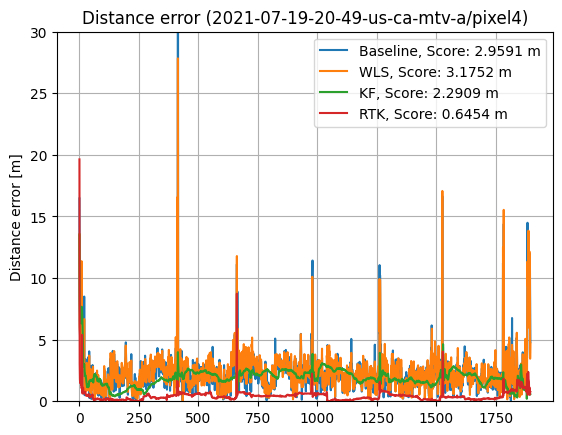

In [12]:
def main():
    gnss = pd.read_csv('data/%s/device_gnss.csv' % path, dtype={'SignalType': str})
    gt = pd.read_csv('data/%s/ground_truth.csv' % path, dtype={'SignalType': str})
    rtk = pd.read_csv('GSDC_2023/data/locations_train_06_03.csv', dtype={'SignalType': str})
    rtk_train = rtk[rtk['tripId'] == path]

    # Add standard Frequency column
    frequency_median = gnss.groupby('SignalType')['CarrierFrequencyHz'].median()
    gnss = gnss.merge(frequency_median, how='left', on='SignalType', suffixes=('', 'Ref'))
    carrier_error = abs(gnss['CarrierFrequencyHz'] - gnss['CarrierFrequencyHzRef'])
    gnss['CarrierErrorHz'] = carrier_error
    utcTimeMillis = gnss['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    gt_len = len(gt)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity
    cov_x = np.full([nepoch, 3, 3], np.nan) # For saving position covariance
    cov_v = np.full([nepoch, 3, 3], np.nan) # For saving velocity covariance  
    score_wls = []
    score_bl = [] 
    score_rtk = []
    score_ukf = [] 
    score_kf = []

    for i, (t_utc, df) in enumerate(tqdm(gnss.groupby('utcTimeMillis'), total=nepoch)):
        if (i ==0) and (nepoch != gt_len) : continue  #First position is not in ground truth in some phone
        df_pr = satellite_selection(df)
        df_prr = satellite_selection(df)

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['RawPseudorangeMeters'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    f_wls, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 f_wls, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                print(f'i = {i} position lsq status = {opt.status}')
            else:
                # Covariance estimation
                cov = np.linalg.inv(opt.jac.T @ Wx @ opt.jac)
                cov_x[i, :, :] = cov[:3, :3]
                x_wls[i, :] = opt.x[:3]
                x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                # Covariance estimation
                cov = np.linalg.inv(opt.jac.T @ Wv @ opt.jac)
                cov_v[i, :, :] = cov[:3, :3]
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

        
        #RTK
        if nepoch == gt_len :
            llh_rtk = rtk_train[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()[i]
        else: 
            llh_rtk = rtk_train[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()[i-1]
        # Baseline
        bl = gnss[gnss['utcTimeMillis'] == utcTimeMillis[i]]
        x_bl = bl[['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
        llh_bl = np.array(pm.ecef2geodetic(x_bl[ 0], x_bl[1], x_bl[2])).T
        # Ground Truth
        llh_wls = np.array(pm.ecef2geodetic(x_wls[i,0], x_wls[i,1], x_wls[i,2])).T
        gt_i = gt[gt['UnixTimeMillis'] == utcTimeMillis[i]]
        llh_gt = gt_i[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()[0]
        if not np.isnan(llh_wls).any():
            score_wls.append(vincenty_distance(llh_wls, llh_gt))
        score_bl.append(vincenty_distance(llh_bl, llh_gt))
        score_rtk.append(vincenty_distance(llh_gt, llh_rtk))

    #Remove 1st position to compare to ground truth
    if nepoch != gt_len :
        x_wls = x_wls[1:,:]
        v_wls = v_wls[1:,:]
        cov_x = cov_x[1:,:,:]
        cov_v = cov_v[1:,:,:]

    # Exclude velocity outliers
    x_wls, v_wls, cov_x, cov_v = exclude_interpolate_outlier(x_wls, v_wls, cov_x, cov_v)

    """
        Lưu trữ lại giá trị ecef
    """
    #Đảm bảo tất cả các mảng đều có cùng độ dài
    min_length = min(len(utcTimeMillis), len(x_wls), len(v_wls), len(cov_x), len(cov_v))
    utcTimeMillis = utcTimeMillis[:min_length]
    ecef_positions = x_wls[:min_length]
    ecef_velocities = v_wls[:min_length]
    cov_x = cov_x[:min_length]
    cov_v = cov_v[:min_length]

    # # Chuyển đổi ma trận hiệp phương sai thành danh sách các giá trị
    # flattened_cov_x = flatten_covariances(cov_x)
    # flattened_cov_v = flatten_covariances(cov_v)

    # # Tạo DataFrame với các dữ liệu cần thiết
    result_df = pd.DataFrame({
        'utcTimeMillis': utcTimeMillis,
        'x': ecef_positions[:, 0],
        'y': ecef_positions[:, 1],
        'z': ecef_positions[:, 2],
        'v_x': ecef_velocities[:, 0],
        'v_y': ecef_velocities[:, 1],
        'v_z': ecef_velocities[:, 2],
    #     'cov_x1': flattened_cov_x[:, 0],
    #     'cov_x2': flattened_cov_x[:, 1],
    #     'cov_x3': flattened_cov_x[:, 2],
    #     'cov_x4': flattened_cov_x[:, 3],
    #     'cov_x5': flattened_cov_x[:, 4],
    #     'cov_x6': flattened_cov_x[:, 5],
    #     'cov_x7': flattened_cov_x[:, 6],
    #     'cov_x8': flattened_cov_x[:, 7],
    #     'cov_x9': flattened_cov_x[:, 8],
    #     'cov_v1': flattened_cov_v[:, 0],
    #     'cov_v2': flattened_cov_v[:, 1],
    #     'cov_v3': flattened_cov_v[:, 2],
    #     'cov_v4': flattened_cov_v[:, 3],
    #     'cov_v5': flattened_cov_v[:, 4],
    #     'cov_v6': flattened_cov_v[:, 5],
    #     'cov_v7': flattened_cov_v[:, 6],
    #     'cov_v8': flattened_cov_v[:, 7],
    #     'cov_v9': flattened_cov_v[:, 8],
    })

    #Lưu DataFrame vào file CSV
    export_name = 'wls_ecef.csv'
    result_df.to_csv(export_name, index=False)
    print(f'Data successfully exported to {export_name}')

    llh_wls = np.array(pm.ecef2geodetic(ecef_positions[:,0], ecef_positions[:,1], ecef_positions[:,2])).T
    position_array = [(time, lat, lon, alt) for time, (lat, lon, alt) in zip(utcTimeMillis, llh_wls)]
    df = pd.DataFrame(position_array, columns=["utcTimeMillis", "Latitude", "Longitude", "Altitude"])
    df.to_csv('llh_wls.csv', index=False)
    print('Data successfully exported to llh_wls.csv')

    
    
    """
        Quaternion và chuyển acccelerometer từ hệ trục body(B) về hệ trục NED
    """
    # Đọc dữ liệu từ tệp CSV
    gps_data = pd.read_csv(r'llh_wls.csv')
    imu_data = pd.read_csv(r'imu_averaged_original.csv')

    # # Kiểm tra tên các cột
    # print("IMU Data Columns:", imu_data.columns)
    # print("GPS Data Columns:", gps_data.columns)

    # Lấy giá trị latitude và longitude đầu tiên từ tệp GPS
    initial_latitude = gps_data["Latitude"].iloc[0]
    initial_longitude = gps_data["Longitude"].iloc[0]
    initial_altitude = gps_data["Altitude"].iloc[0]
    # Tạo đối tượng Madgwick và CCS
    filter = Madgwick()

    # Xử lý dữ liệu và lưu các giá trị roll, pitch, yaw, accel và gyro
    results_ecef = []
    results_ned = []

    for _, gps_row in gps_data.iterrows():
        utc_time = gps_row["utcTimeMillis"]
        
        # Tìm hàng tương ứng trong imu_data bằng utcTimeMillis
        imu_row = imu_data[imu_data["utcTimeMillis"] == utc_time]
        if imu_row.empty:
            continue  # Bỏ qua nếu không tìm thấy hàng tương ứng
        
        imu_row = imu_row.iloc[0]  # Lấy hàng đầu tiên (vì tìm kiếm theo utcTimeMillis chỉ nên trả về một hàng)
        filter.updateRollPitchYaw(
            imu_row["mean_accel_x"], imu_row["mean_accel_y"], imu_row["mean_accel_z"],
            imu_row["mean_gyro_x"], imu_row["mean_gyro_y"], imu_row["mean_gyro_z"],
            imu_row["mean_mag_x"], imu_row["mean_mag_y"], imu_row["mean_mag_z"], dt=1
        )
        
        # latitude = gps_row["Latitude"]
        # longitude = gps_row["Longitude"]
        

        # Chuyển đổi từ body sang ECEF
        phi, theta, psi = filter.roll, filter.pitch, filter.yaw
        ccs = CCS(phi, theta, psi, initial_latitude, initial_longitude, initial_altitude)
        accel_ned = ccs.body_to_ned(
            imu_row["mean_accel_x"], imu_row["mean_accel_y"], imu_row["mean_accel_z"]
        )
        gyro_ned = ccs.body_to_ned(
            imu_row["mean_gyro_x"], imu_row["mean_gyro_y"], imu_row["mean_gyro_z"]
        )

        results_ned.append({
            "utcTimeMillis": imu_row["utcTimeMillis"],
            "accel_ned_x": accel_ned[0],
            "accel_ned_y": accel_ned[1],
            "accel_ned_z": accel_ned[2],
            "gyro_ned_x": gyro_ned[0],
            "gyro_ned_y": gyro_ned[1],
            "gyro_ned_z": gyro_ned[2]
        })


    # Chuyển đổi dữ liệu đã xử lý thành DataFrame
    output_df = pd.DataFrame(results_ned)
    # Đường dẫn tệp CSV đầu ra
    output_csv_file_path = "imu_ned.csv"
    # Xuất dữ liệu ra tệp CSV
    output_df.to_csv(output_csv_file_path, index=False)
    # Hiển thị vài dòng đầu tiên của kết quả để kiểm tra
    print(output_df.head())

    x_ned = np.array(ccs.ecef_to_ned(x_wls[:,0], x_wls[:,1], x_wls[:,2])).T
    v_ned = np.array(ccs.vecef_to_ned(v_wls[:,0], v_wls[:,1], v_wls[:,2])).T
    # x_ned = np.array(pm.ecef2enu(x_wls[:,0], x_wls[:,1], x_wls[:,2],37.42829511937677,-122.07252317703472,-29.11495230431745)).T
    # v_ned = np.array(pm.ecef2enuv(v_wls[:,0], v_wls[:,1], v_wls[:,2],37.42829511937677,-122.07252317703472)).T
    # Tạo DataFrame từ dữ liệu
    data = {
        'utcTimeMillis': utcTimeMillis,
        'x_ned': x_ned[:, 0],
        'y_ned': x_ned[:, 1],
        'z_ned': x_ned[:, 2],
        'vx_ned': v_ned[:, 0],
        'vy_ned': v_ned[:, 1],
        'vz_ned': v_ned[:, 2],
    }

    df = pd.DataFrame(data)
    # Xuất DataFrame ra file CSV
    df.to_csv('pos_vel_ned.csv', index=False)
    print("Data đã được xuất ra file output.csv")


    """
        Calculate score and plot distance error 
    """
    # Get ground_truth
    llh_gt = gt[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()
    # Calculate score KF
    kf = KalmanFilter()
    x_kf, _ = kf.kalman_filter(x_wls, v_wls, cov_x, cov_v)                # Stage 2: KF for position 
    llh_kf = np.array(pm.ecef2geodetic(x_kf[:,0], x_kf[:,1], x_kf[:,2])).T
    # Tạo DataFrame từ dữ liệu
    data = {
        'utcTimeMillis': utcTimeMillis,
        'Latitude': llh_kf[:, 0],
        'Longitude': llh_kf[:, 1]
    }
    df = pd.DataFrame(data)
    # Xuất DataFrame ra file CSV
    df.to_csv('kf_latlong.csv', index=False)
    print("Data đã được xuất ra file output.csv")

    # Calculate score UKF
    # ukf_data_path = r'C:\Users\luan1\OneDrive\Desktop\DATN_20232\Code\KalmanFilter\UKF_25_5_2024\ukf_gnss_latlong.csv'
    # ukf_data = pd.read_csv(ukf_data_path)
    # llh_ukf = ukf_data[['Latitude', 'Longitude']].to_numpy()
    # for i in range(len(llh_gt)):
    #     score_ukf_i = vincenty_distance(llh_gt[i], llh_ukf[i])
    #     score_ukf.append(score_ukf_i)

    # Calculate score all method    
    for i in range(len(llh_gt)):
        score_kf_i = vincenty_distance(llh_gt[i], llh_kf[i])
        score_kf.append(score_kf_i)
    score_all_wls = np.mean([np.quantile(score_wls, 0.50), np.quantile(score_wls, 0.95)])
    score_all_bl = np.mean([np.quantile(score_bl, 0.50), np.quantile(score_bl, 0.95)])
    score_all_kf = np.mean([np.quantile(score_kf, 0.50), np.quantile(score_kf, 0.95)])
    # score_all_ukf = np.mean([np.quantile(score_ukf, 0.50), np.quantile(score_ukf, 0.95)])
    score_all_rtk = np.mean([np.quantile(score_rtk, 0.50), np.quantile(score_rtk, 0.95)])
    print("Baseline score: ", score_all_bl)
    print("WLS score: ", score_all_wls)
    print("KF score: ", score_all_kf)
    # print("UKF score: ", score_all_ukf)
    print("RTK score: ", score_all_rtk)


    #Plot distance error
    plt.figure()
    plt.title(f'Distance error ({path})')
    plt.ylabel('Distance error [m]')
    plt.plot(score_bl, label=f'Baseline, Score: {score_all_bl:.4f} m')
    plt.plot(score_wls, label=f'WLS, Score: {score_all_wls:.4f} m')
    plt.plot(score_kf, label=f'KF, Score: {score_all_kf:.4f} m')
    # plt.plot(score_ukf, label=f'UKF, Score: {score_all_ukf:.4f} m')  
    plt.plot(score_rtk, label=f'RTK, Score: {score_all_rtk:.4f} m')
    plt.legend()
    plt.grid()
    plt.ylim([0, 30])
    plt.show()
    


if __name__ == "__main__":
    main()